## Download repo


In [1]:
import os
import shutil
import zipfile
import urllib.request

def download_repo(url, save_to):
    zip_filename = save_to + '.zip'
    urllib.request.urlretrieve(url, zip_filename)
    
    if os.path.exists(save_to):
        shutil.rmtree(save_to)
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    del zip_ref
    assert os.path.exists(save_to)

In [2]:
REPO_PATH = 'LinearizedNNs-master'

download_repo(url='https://github.com/maxkvant/LinearizedNNs/archive/master.zip',
              save_to=REPO_PATH)

## Imports

In [3]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST


from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot, print_sizes
from pytorch_impl.nns.primitives import Conv, Flatten, Normalize, ReLU2
from from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [5]:
device = torch.device('cuda:0') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda', index=0)

In [6]:
def compute_kernels(models, X_train, X_test, device):
    with torch.no_grad():
        X_train = X_train.to(device)
        X_test  = X_test.to(device)

        n_train = len(X_train)
        n_test  = len(X_test)

        train_kernel = torch.zeros([n_train, n_train]).double().to(device)
        test_kernel  = torch.zeros([n_test,  n_train]).double().to(device)

        m = 0
        start_time = time.time()

        for model_i, model in enumerate(models):
            model = model.to(device)
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done. time {time.time() - start_time:.0f}s")

            train_features = model.readout(X_train) 
            test_features  = model.readout(X_test)

            m += 1

            train_kernel += torch.matmul(train_features, train_features.T).double()
            test_kernel  += torch.matmul(test_features,  train_features.T).double()

        train_kernel /= m
        test_kernel  /= m

        return train_kernel.float(), test_kernel.float()

In [7]:
def compute_kernels_numpy(models, X_train, X_test, device, block_size=1280):
    with torch.no_grad():
        X_train = X_train.to(device)
        X_test  = X_test.to(device)

        n_train = len(X_train)
        n_test  = len(X_test)

        train_kernel = np.zeros([n_train, n_train])
        test_kernel  = np.zeros([n_test,  n_train])

        m = 0
        start_time = time.time()
        
        for model_i, model in enumerate(models):
            model = model.to(device)
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done. time {time.time() - start_time:.0f}s")
            m += 1

            test_features  = model.readout(X_test)            
            
            for lj in range(0, n_train, block_size):
                rj = min(n_train, lj + block_size)
                train_features_J = model.readout(X_train[lj: rj])
                test_kernel[:,lj: rj]  += torch.matmul(test_features,  train_features_J.T).cpu().numpy()
                
                for li in range(0, rj, block_size):
                    ri = min(n_train, li + block_size)
                    train_features_I = model.readout(X_train[li: ri])
                    block = torch.matmul(train_features_I, train_features_J.T).cpu().numpy()
                    train_kernel[li: ri, lj: rj] += block
                    if li != lj:
                        train_kernel[lj: rj, li: ri] += block.T
                    
        train_kernel /= m
        test_kernel  /= m
        return train_kernel, test_kernel

## Cifar10

### Empirical kernel on Cifar10[:1280]

In [8]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 45s, sys: 1min 6s, total: 4min 51s
Wall time: 46.9 s


In [9]:
N = 1280

X_train      = torch.tensor(X_train[:N]).float()
X_test       = torch.tensor(X_test[:N]).float()
labels_train = torch.tensor(labels_train[:N], dtype=torch.long)
labels_test  = torch.tensor(labels_test[:N],  dtype=torch.long)

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

In [10]:
model = Myrtle10(num_filters=1, groups=50).to(device)
print_sizes(model)
model.forward(X_train[:5].to(device))

torch.Size([50, 3, 3, 3])
torch.Size([100, 1, 3, 3])
torch.Size([200, 2, 3, 3])
torch.Size([400, 4, 3, 3])
torch.Size([800, 8, 3, 3])
torch.Size([1600, 16, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([10, 1600])
torch.Size([10])
1706660


tensor([[-0.0213, -0.0074, -0.0181, -0.0145,  0.0139,  0.0121, -0.0361,  0.0162,
         -0.0196,  0.0156],
        [-0.0219, -0.0082, -0.0192, -0.0125,  0.0146,  0.0144, -0.0340,  0.0156,
         -0.0207,  0.0165],
        [-0.0205, -0.0077, -0.0167, -0.0141,  0.0127,  0.0153, -0.0315,  0.0153,
         -0.0210,  0.0166],
        [-0.0212, -0.0082, -0.0174, -0.0141,  0.0140,  0.0144, -0.0352,  0.0151,
         -0.0202,  0.0156],
        [-0.0206, -0.0100, -0.0165, -0.0143,  0.0142,  0.0140, -0.0316,  0.0188,
         -0.0224,  0.0161]], device='cuda:0', grad_fn=<AddmmBackward>)

In [11]:
torch.manual_seed(3)

n_models = 500

# 5000 * 32 = 160k

models = [Myrtle10(num_filters=1, groups=50) for _ in range(n_models)]
n_models

500

In [12]:
X_test = X_test[:2000]

In [13]:
%%time

train_kernel, test_kernel = compute_kernels_numpy(models, X_train, X_test, device, block_size=640)

train_kernel = torch.from_numpy(train_kernel).float().to(device)
test_kernel  = torch.from_numpy(test_kernel).float().to(device)

0 models done. time 0s
1 models done. time 0s
2 models done. time 1s
4 models done. time 2s
8 models done. time 3s
16 models done. time 7s
32 models done. time 14s
64 models done. time 27s
128 models done. time 55s
256 models done. time 109s
CPU times: user 2min 40s, sys: 51.9 s, total: 3min 32s
Wall time: 3min 32s


In [14]:
train_kernel[:5,:5]

tensor([[1.0000, 0.9962, 0.9938, 0.9971, 0.9959],
        [0.9962, 1.0000, 0.9928, 0.9970, 0.9946],
        [0.9938, 0.9928, 1.0000, 0.9930, 0.9930],
        [0.9971, 0.9970, 0.9930, 1.0000, 0.9951],
        [0.9959, 0.9946, 0.9930, 0.9951, 1.0000]], device='cuda:0')

In [15]:
test_kernel[:5,:5]

tensor([[0.9960, 0.9961, 0.9944, 0.9964, 0.9947],
        [0.9945, 0.9948, 0.9920, 0.9946, 0.9953],
        [0.9951, 0.9951, 0.9947, 0.9947, 0.9930],
        [0.9946, 0.9950, 0.9936, 0.9945, 0.9938],
        [0.9967, 0.9964, 0.9922, 0.9969, 0.9942]], device='cuda:0')

In [16]:
lr = 1e5

n = len(train_kernel)
reg = torch.eye(n).to(device) * 0e-7

exp_term = - lr * compute_exp_term(- lr * (train_kernel + reg), device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.6547, device='cuda:0')

### Std of empirical kernel on Cifar10[:1280]

In [8]:
%%time

num_classes = 10

X_train, labels_train, X_test, labels_test = get_cifar_zca()

n_test      = 2000
X_test      = X_test[:n_test]
labels_test = labels_test[:n_test]

X_train      = torch.tensor(X_train).float()
X_test       = torch.tensor(X_test).float()
labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_test  = torch.tensor(labels_test,  dtype=torch.long)

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 4min 14s, sys: 1min 37s, total: 5min 52s
Wall time: 58.9 s


In [9]:
def get_accuracies(models, X_train_full, labels_train, X_test, labels_test, samples=20, sample_size=1280, lr=1e5):
    accs = []
    n_train = len(X_train_full)
    
    X_test      = X_test.to(device)
    
    for sample_i in range(samples):
        if (sample_i & (sample_i - 1)) == 0:
            print()
            print(f"!!! {sample_i} samples done")
        index = torch.randperm(n_train)[:sample_size]
        X_train = X_train_full[index].to(device)
        y_train = to_one_hot(labels_train[index], num_classes).to(device)
        
        train_kernel, test_kernel = compute_kernels(models, X_train, X_test, device)
        
        exp_term = - lr * compute_exp_term(- lr * train_kernel, device)
        y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
        acc = (y_pred.argmax(dim=1) == labels_test.to(device)).float().mean().item()
        
        print(f"sample{sample_i} of size {len(index)} done, accuracy = {acc}")
        accs.append(acc)
    return accs

In [10]:
%%time
torch.manual_seed(0)

n_models = 250

# 5000 * 32 = 160k

models = [Myrtle5(num_filters=1, groups=200) for _ in range(n_models)]
myrtle_5_accs = get_accuracies(models, X_train, labels_train, X_test, labels_test, samples=5)

print(f"average={np.average(myrtle_5_accs)} std={np.std(myrtle_5_accs)}") 

myrtle_5_accs


!!! 0 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 1s
8 models done. time 2s
16 models done. time 5s
32 models done. time 10s
64 models done. time 19s
128 models done. time 35s
sample0 of size 1280 done, accuracy = 0.643500030040741

!!! 1 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 2s
32 models done. time 7s
64 models done. time 16s
128 models done. time 32s
sample1 of size 1280 done, accuracy = 0.6455000042915344

!!! 2 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 2s
32 models done. time 7s
64 models done. time 18s
128 models done. time 33s
sample2 of size 1280 done, accuracy = 0.6365000009536743
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models do

[0.643500030040741,
 0.6455000042915344,
 0.6365000009536743,
 0.6440000534057617,
 0.64000004529953]

In [11]:
%%time
torch.manual_seed(0)

n_models = 250

# 5000 * 32 = 160k

models = [Myrtle7(num_filters=1, groups=50) for _ in range(n_models)]
myrtle_7_accs = get_accuracies(models, X_train, labels_train, X_test, labels_test, samples=5)

print(f"average={np.average(myrtle_7_accs)} std={np.std(myrtle_7_accs)}") 

myrtle_7_accs


!!! 0 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 1s
8 models done. time 1s
16 models done. time 2s
32 models done. time 4s
64 models done. time 7s
128 models done. time 17s
sample0 of size 1280 done, accuracy = 0.6440000534057617

!!! 1 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 1s
32 models done. time 2s
64 models done. time 5s
128 models done. time 15s
sample1 of size 1280 done, accuracy = 0.6465000510215759

!!! 2 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 1s
32 models done. time 2s
64 models done. time 5s
128 models done. time 15s
sample2 of size 1280 done, accuracy = 0.655500054359436
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. 

[0.6440000534057617,
 0.6465000510215759,
 0.655500054359436,
 0.6525000333786011,
 0.6665000319480896]

In [12]:
%%time
torch.manual_seed(0)

n_models = 250

# 5000 * 32 = 160k

models = [Myrtle10(num_filters=1, groups=50) for _ in range(n_models)]
myrtle_10_accs = get_accuracies(models, X_train, labels_train, X_test, labels_test, samples=5)

print(f"average={np.average(myrtle_10_accs)} std={np.std(myrtle_10_accs)}") 

myrtle_10_accs


!!! 0 samples done
0 models done. time 0s
1 models done. time 1s
2 models done. time 1s
4 models done. time 2s
8 models done. time 4s
16 models done. time 8s
32 models done. time 16s
64 models done. time 30s
128 models done. time 61s
sample0 of size 1280 done, accuracy = 0.655500054359436

!!! 1 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 2s
16 models done. time 5s
32 models done. time 12s
64 models done. time 24s
128 models done. time 44s
sample1 of size 1280 done, accuracy = 0.671500027179718

!!! 2 samples done
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 3s
32 models done. time 8s
64 models done. time 17s
128 models done. time 37s
sample2 of size 1280 done, accuracy = 0.671500027179718
0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models don

[0.655500054359436,
 0.671500027179718,
 0.671500027179718,
 0.6735000610351562,
 0.656000018119812]

### Empirical kernel on Cifar10[:12800]

In [22]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 42s, sys: 1min 3s, total: 4min 45s
Wall time: 42.3 s


In [23]:
N = 12800

X_train      = torch.tensor(X_train[:N]).float()
X_test       = torch.tensor(X_test[:N]).float()
labels_train = torch.tensor(labels_train[:N], dtype=torch.long)
labels_test  = torch.tensor(labels_test[:N],  dtype=torch.long)

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

In [24]:
X_test      = X_test[:2000]
y_test      = y_test[:2000]
labels_test = labels_test[:2000]

In [25]:
model = Myrtle10(num_filters=1, groups=50).to(device)
print_sizes(model)
model.forward(X_train[:5].to(device))

torch.Size([50, 3, 3, 3])
torch.Size([100, 1, 3, 3])
torch.Size([200, 2, 3, 3])
torch.Size([400, 4, 3, 3])
torch.Size([800, 8, 3, 3])
torch.Size([1600, 16, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([1600, 32, 3, 3])
torch.Size([10, 1600])
torch.Size([10])
1706660


tensor([[-0.0185, -0.0091, -0.0053,  0.0078,  0.0135,  0.0061, -0.0255,  0.0179,
         -0.0041, -0.0440],
        [-0.0184, -0.0072, -0.0054,  0.0058,  0.0134,  0.0068, -0.0260,  0.0203,
         -0.0045, -0.0449],
        [-0.0182, -0.0088, -0.0058,  0.0079,  0.0143,  0.0075, -0.0240,  0.0190,
         -0.0061, -0.0453],
        [-0.0188, -0.0071, -0.0062,  0.0065,  0.0142,  0.0057, -0.0258,  0.0207,
         -0.0046, -0.0444],
        [-0.0170, -0.0070, -0.0054,  0.0088,  0.0145,  0.0066, -0.0266,  0.0187,
         -0.0053, -0.0451]], device='cuda:0', grad_fn=<AddmmBackward>)

In [40]:
torch.manual_seed(1)

n_models = 500

# 5000 * 32 = 160k

models = [Myrtle7(num_filters=1, groups=50) for _ in range(n_models)]
n_models

500

In [41]:
%%time

train_kernel, test_kernel = compute_kernels_numpy(models, X_train, X_test, device, block_size=4 * 1280)
train_kernel = torch.from_numpy(train_kernel).float().to(device)
test_kernel  = torch.from_numpy(test_kernel).float().to(device)

0 models done. time 0s
1 models done. time 4s
2 models done. time 6s
4 models done. time 12s
8 models done. time 22s
16 models done. time 42s
32 models done. time 82s
64 models done. time 164s
128 models done. time 325s
256 models done. time 648s
CPU times: user 18min 18s, sys: 2min 48s, total: 21min 6s
Wall time: 21min 5s


In [42]:
train_kernel[:5,:5]

tensor([[1.0000, 0.9956, 0.9937, 0.9964, 0.9954],
        [0.9956, 1.0000, 0.9931, 0.9967, 0.9944],
        [0.9937, 0.9931, 1.0000, 0.9933, 0.9941],
        [0.9964, 0.9967, 0.9933, 1.0000, 0.9946],
        [0.9954, 0.9944, 0.9941, 0.9946, 1.0000]], device='cuda:0')

In [43]:
test_kernel[:5,:5]

tensor([[0.9956, 0.9959, 0.9945, 0.9960, 0.9949],
        [0.9934, 0.9942, 0.9920, 0.9930, 0.9947],
        [0.9950, 0.9956, 0.9946, 0.9953, 0.9940],
        [0.9932, 0.9941, 0.9933, 0.9931, 0.9939],
        [0.9964, 0.9959, 0.9923, 0.9966, 0.9939]], device='cuda:0')

In [45]:
lr = 1e5

n = len(train_kernel)
reg = torch.eye(n).to(device) * 0e-4

exp_term = - lr * compute_exp_term(- lr * (train_kernel + reg), device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.7875, device='cuda:0')

In [58]:
np.savez('../data/myrtle7_kernels_12k.npz', 
         train_kernel=train_kernel,
         test_kernel=test_kernel,
         labels_train=labels_train.cpu().numpy(),
         labels_test=labels_test.cpu().numpy())

In [59]:
myrtle7_kernels_12k = np.load('../data/myrtle7_kernels_12k.npz')
list(myrtle7_kernels_12k)

['train_kernel', 'test_kernel', 'labels_train', 'labels_test']

In [60]:
myrtle7_kernels_12k['train_kernel'].shape, myrtle7_kernels_12k['test_kernel'].shape

((12800, 12800), (2000, 12800))

In [61]:
myrtle7_kernels_12k['labels_train'].shape, myrtle7_kernels_12k['labels_test'].shape

((12800,), (2000,))

In [62]:
myrtle7_kernels_12k['labels_train'][:5], myrtle7_kernels_12k['labels_test'][:5]

(array([6, 9, 9, 4, 1]), array([3, 8, 8, 0, 6]))

In [63]:
labels_train[:5], labels_test[:5]

(tensor([6, 9, 9, 4, 1]), tensor([3, 8, 8, 0, 6]))

## Full Cifar10

In [17]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 42s, sys: 1min 3s, total: 4min 45s
Wall time: 43.4 s


In [18]:
X_train      = torch.tensor(X_train).float()
X_test       = torch.tensor(X_test).float()
labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_test  = torch.tensor(labels_test,  dtype=torch.long)

In [19]:
X_test      = X_test[:2000]
labels_test = labels_test[:2000]

In [20]:
torch.manual_seed(0)

n_models = 500

# 5000 * 32 = 160k

models = [Myrtle10(num_filters=1, groups=50) for _ in range(n_models)]
n_models

500

In [ ]:
%%time

train_kernel, test_kernel = compute_kernels_numpy(models, X_train, X_test, device, block_size=4 * 1280)

0 models done. time 0s
1 models done. time 94s
2 models done. time 153s
4 models done. time 272s
8 models done. time 511s
16 models done. time 990s
32 models done. time 1952s
64 models done. time 3900s
128 models done. time 7800s
256 models done. time 15608s


In [29]:
"""
np.savez('../data/myrtle10_kernels.npz', 
         train_kernel=train_kernel,
         test_kernel=test_kernel,
         labels_train=labels_train.cpu().numpy(),
         labels_test=labels_test.cpu().numpy())
"""

In [30]:
train_kernel.shape

(50000, 50000)

In [31]:
test_kernel.shape

(2000, 50000)

In [32]:
kernels = np.load('../data/myrtle10_kernels.npz')
list(kernels)

['train_kernel', 'test_kernel', 'labels_train', 'labels_test']

In [33]:
kernels['test_kernel'].shape, kernels['labels_train'].shape, kernels['labels_test'].shape

((2000, 50000), (50000,), (2000,))

In [34]:
kernels['train_kernel'].shape

(50000, 50000)

## Neural networks

In [6]:
%%time

X_train, y_train, X_test, y_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 50s, sys: 1min 7s, total: 4min 57s
Wall time: 44.8 s


In [7]:
torch.manual_seed(0)

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long), transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

epoch 0/60, 0s since start


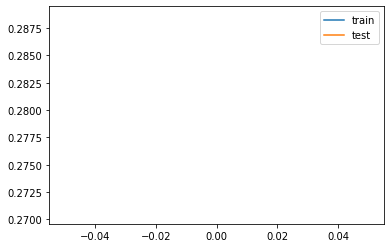

epoch 1/60, 74s since start


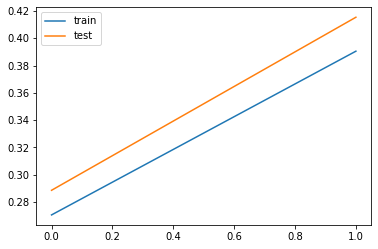

epoch 2/60, 149s since start


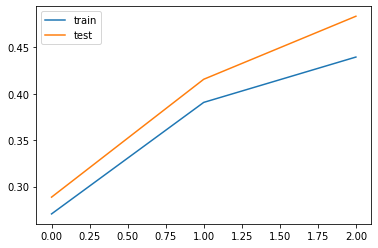

epoch 3/60, 223s since start


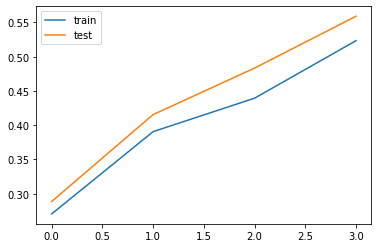

epoch 4/60, 297s since start


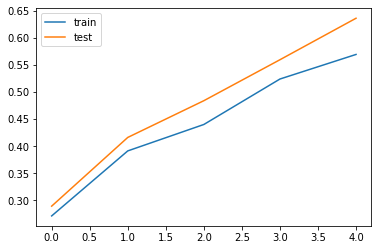

epoch 5/60, 372s since start


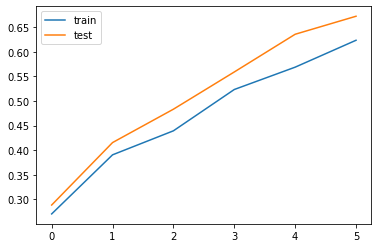

epoch 6/60, 446s since start


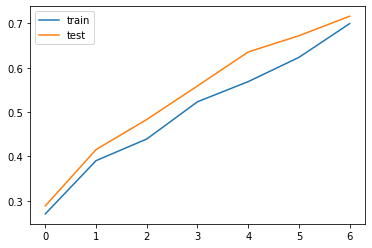

epoch 7/60, 520s since start


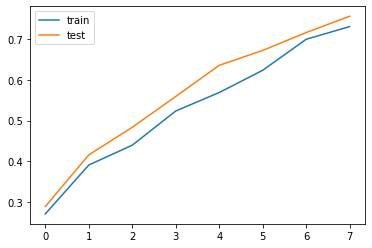

epoch 8/60, 594s since start


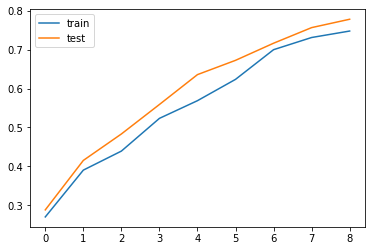

epoch 9/60, 669s since start


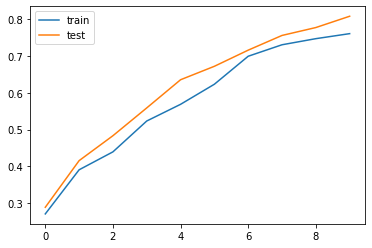

epoch 10/60, 743s since start


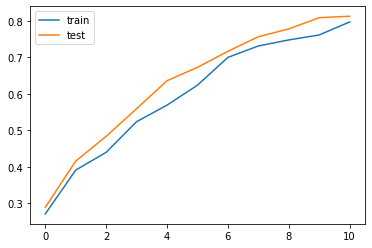

epoch 11/60, 817s since start


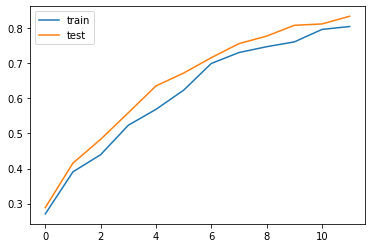

epoch 12/60, 892s since start


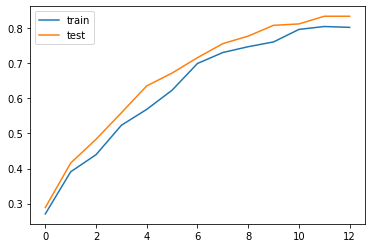

epoch 13/60, 966s since start


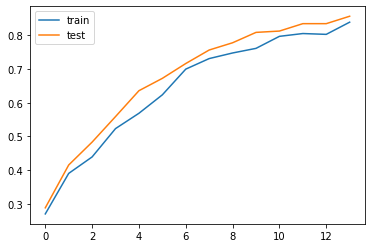

epoch 14/60, 1040s since start


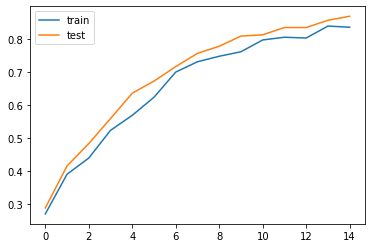

epoch 15/60, 1115s since start


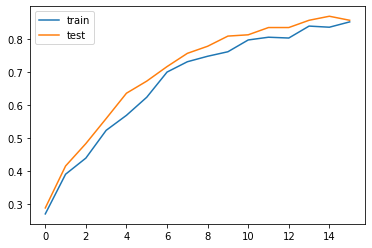

epoch 16/60, 1189s since start


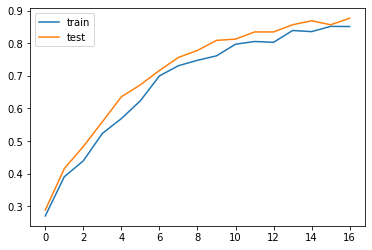

epoch 17/60, 1263s since start


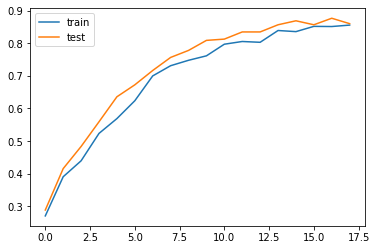

epoch 18/60, 1337s since start


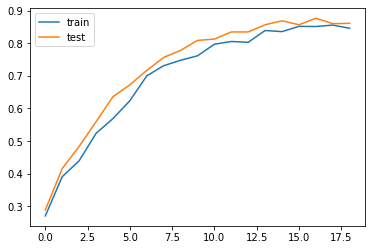

epoch 19/60, 1412s since start


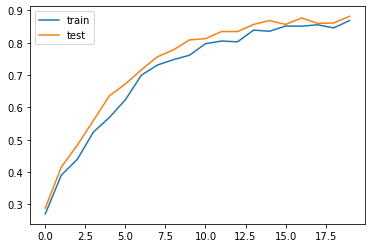

epoch 20/60, 1486s since start


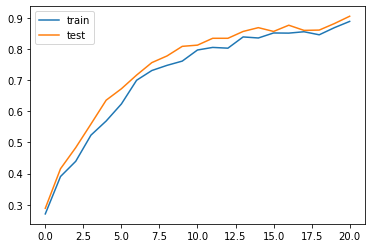

epoch 21/60, 1560s since start


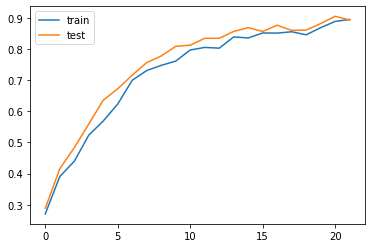

epoch 22/60, 1634s since start


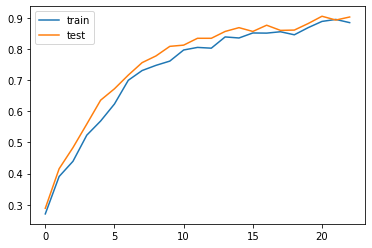

epoch 23/60, 1709s since start


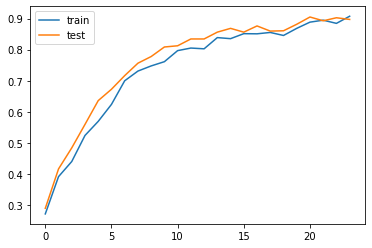

epoch 24/60, 1783s since start


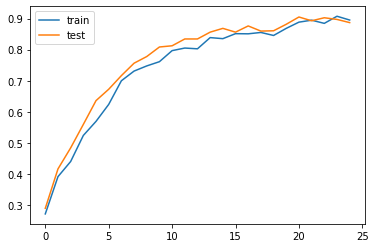

epoch 25/60, 1857s since start


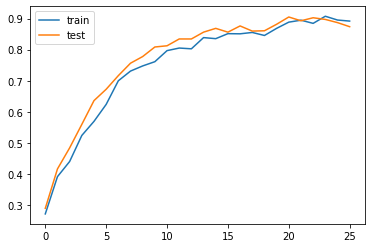

epoch 26/60, 1931s since start


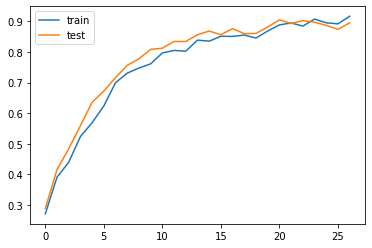

epoch 27/60, 2006s since start


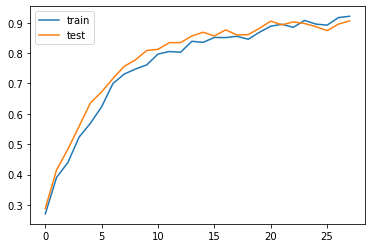

epoch 28/60, 2080s since start


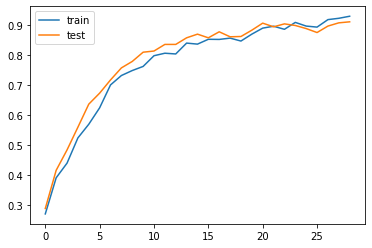

epoch 29/60, 2154s since start


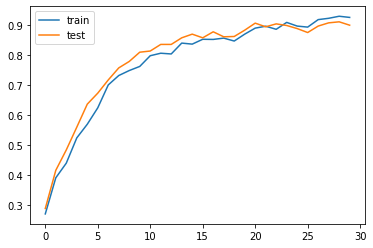

epoch 30/60, 2229s since start


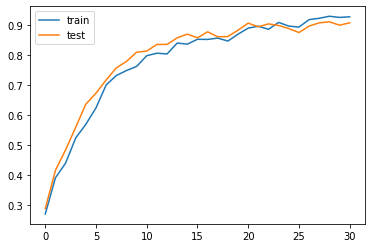

epoch 31/60, 2303s since start


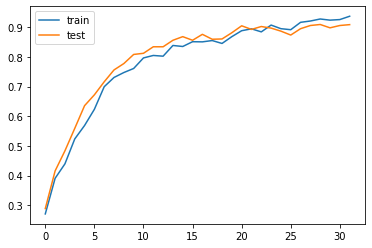

epoch 32/60, 2377s since start


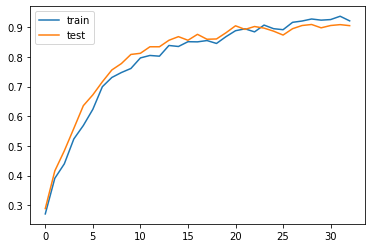

epoch 33/60, 2451s since start


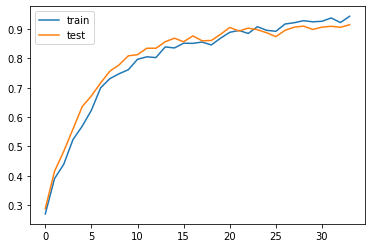

epoch 34/60, 2526s since start


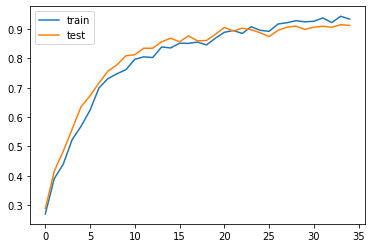

epoch 35/60, 2600s since start


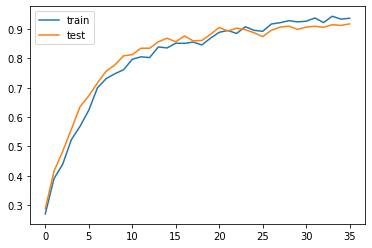

epoch 36/60, 2674s since start


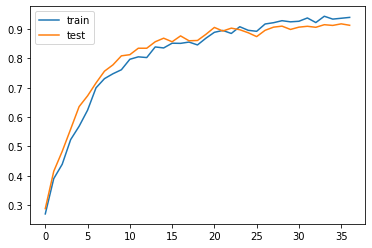

epoch 37/60, 2748s since start


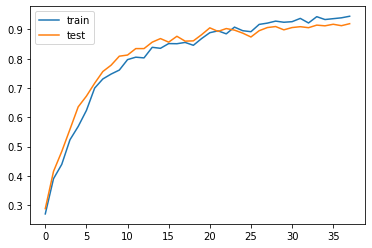

epoch 38/60, 2823s since start


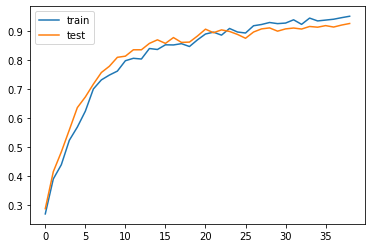

epoch 39/60, 2897s since start


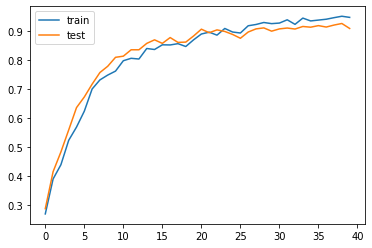

epoch 40/60, 2971s since start


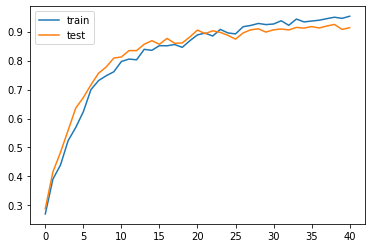

epoch 41/60, 3045s since start


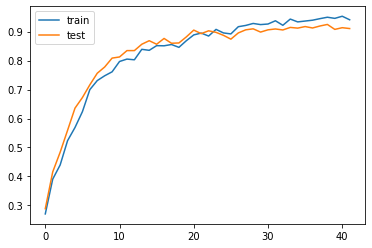

epoch 42/60, 3120s since start


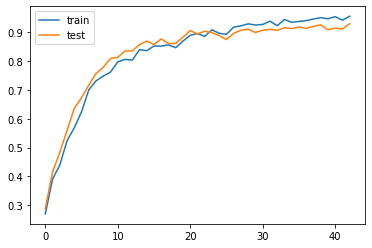

epoch 43/60, 3194s since start


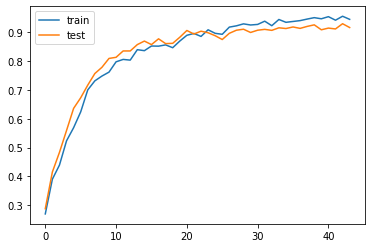

epoch 44/60, 3268s since start


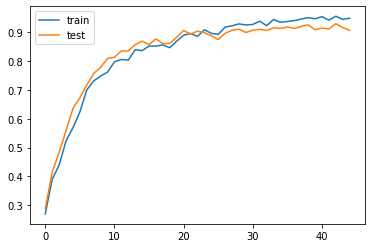

epoch 45/60, 3342s since start


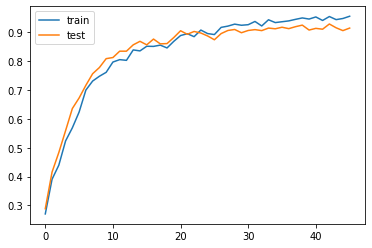

epoch 46/60, 3417s since start


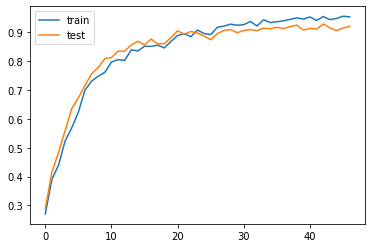

epoch 47/60, 3491s since start


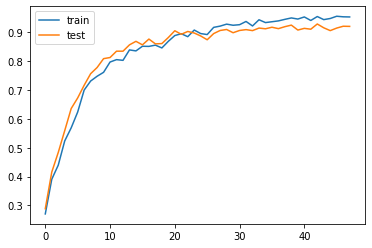

epoch 48/60, 3565s since start


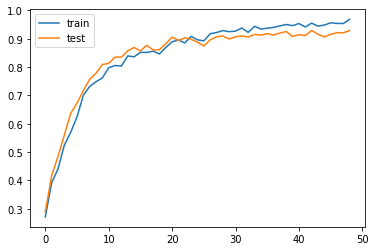

epoch 49/60, 3640s since start


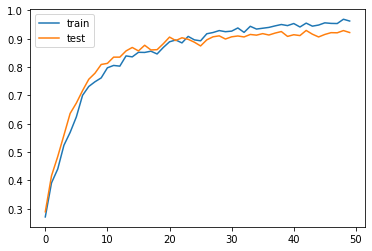

epoch 50/60, 3714s since start


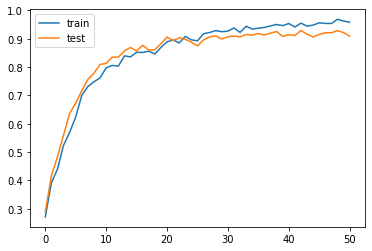

epoch 51/60, 3788s since start


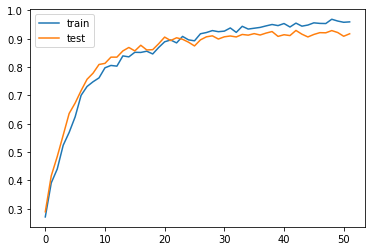

epoch 52/60, 3862s since start


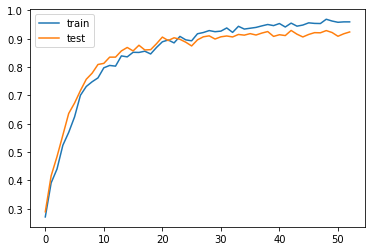

epoch 53/60, 3937s since start


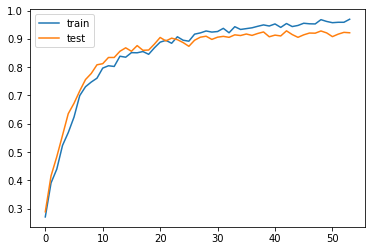

epoch 54/60, 4011s since start


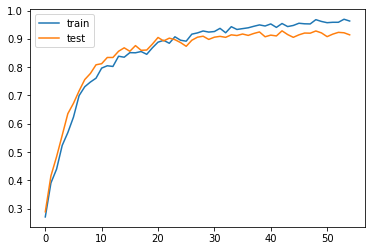

epoch 55/60, 4085s since start


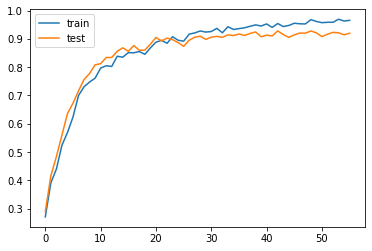

epoch 56/60, 4159s since start


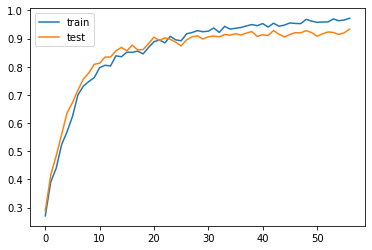

epoch 57/60, 4234s since start


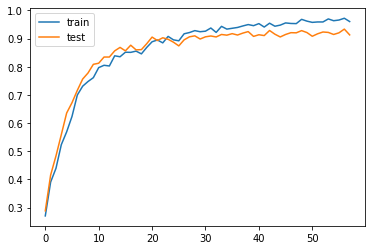

epoch 58/60, 4308s since start


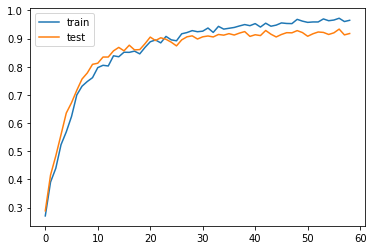

epoch 59/60, 4382s since start


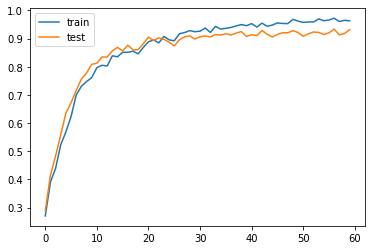

training took 4456s
test_accuracy 0.924


In [15]:
model = Myrtle10(num_filters=512).to(device)
learning_rate = 0.02

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=60, learning_rate=learning_rate)

In [16]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.9236550632911392

In [21]:
ClassifierTraining(estimator, device).get_accuracy(train_loader)

0.9685342071978066

epoch 0/20, 0s since start


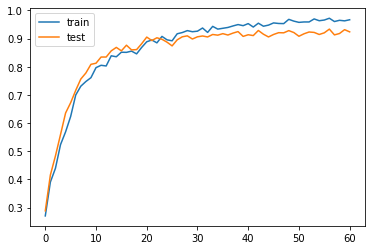

epoch 1/20, 74s since start


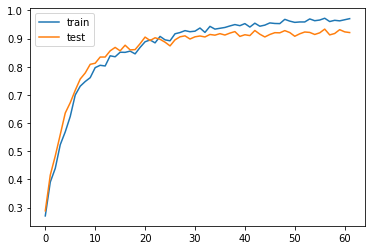

epoch 2/20, 149s since start


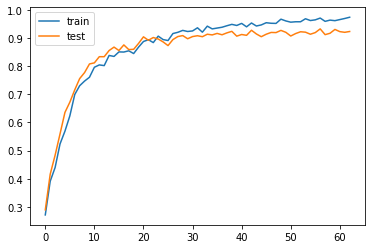

epoch 3/20, 223s since start


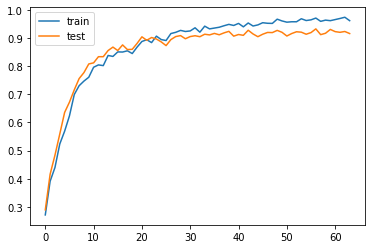

epoch 4/20, 337s since start


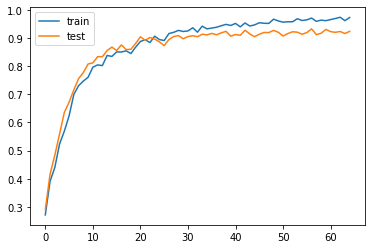

epoch 5/20, 464s since start


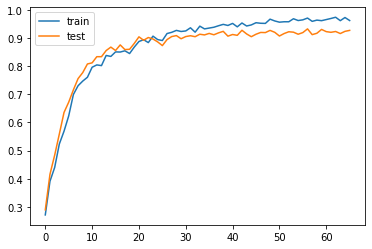

epoch 6/20, 538s since start


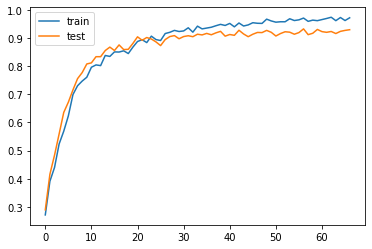

epoch 7/20, 612s since start


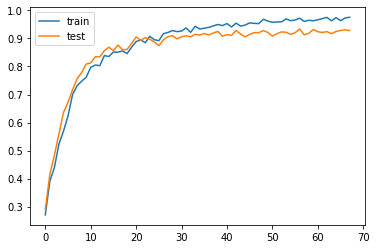

epoch 8/20, 687s since start


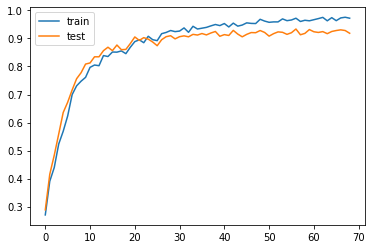

epoch 9/20, 769s since start


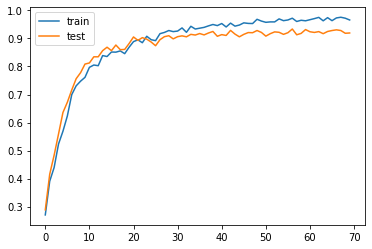

epoch 10/20, 894s since start


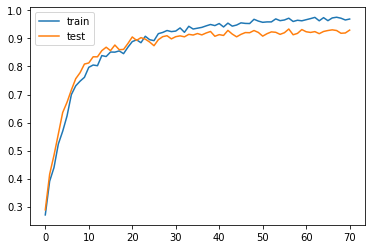

epoch 11/20, 1024s since start


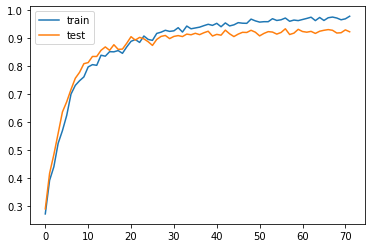

epoch 12/20, 1159s since start


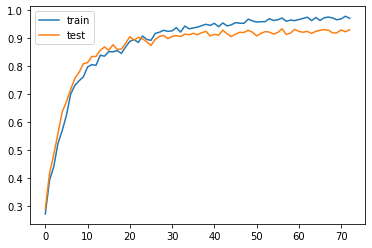

epoch 13/20, 1321s since start


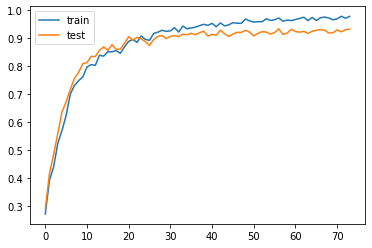

epoch 14/20, 1395s since start


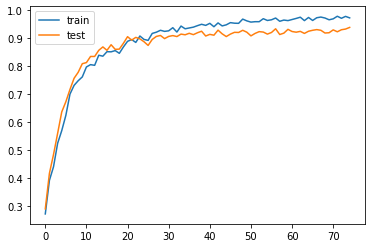

epoch 15/20, 1469s since start


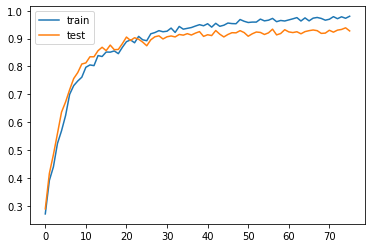

epoch 16/20, 1544s since start


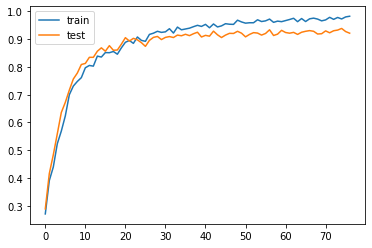

epoch 17/20, 1618s since start


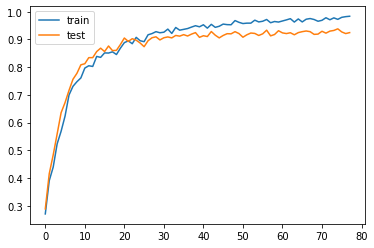

epoch 18/20, 1693s since start


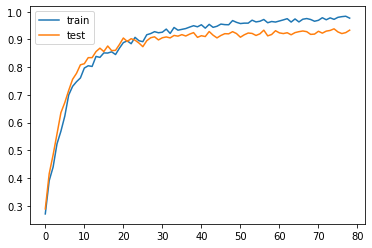

epoch 19/20, 1767s since start


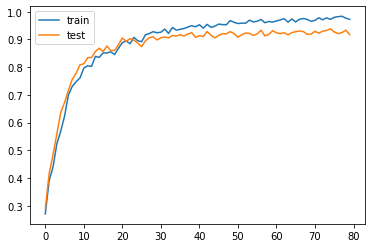

training took 1841s
test_accuracy 0.923


In [31]:
training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [32]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.9234572784810127

In [33]:
ClassifierTraining(estimator, device).get_accuracy(train_loader)

0.9733176151257189

In [34]:
N = len(X_train)
print(N)

targets = []
step = 1024
for l in range(0, N, step):
    r = min(l + step, N)
    X = torch.tensor(X_train[l: r]).float().to(device)
    targets.append(model.forward(X).detach().cpu())
targets = torch.cat(targets, dim=0)
targets.size()

50000


torch.Size([50000, 10])

In [35]:
# np.savez('../data/cifar10_targets_2.npz', targets=targets.numpy())

In [30]:
np.load('../data/cifar10_targets_2.npz')['targets'][0]

array([-1.5718243 , -1.562764  ,  0.6263199 ,  0.84335184, -0.20396045,
       -1.004281  ,  7.5410256 , -1.7956138 , -1.4516151 , -1.7202188 ],
      dtype=float32)

In [36]:
PATH = "../data/myrtle10_512_channels.pt"
# torch.save(model.state_dict(), PATH)

## Extra stats

0.051094893

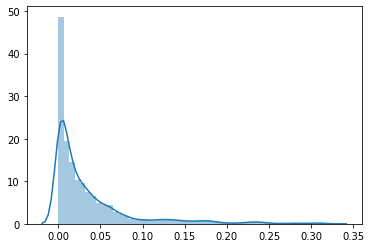

In [18]:
model = Myrtle10(num_filters=128, groups=2).to(device)
for batch_id, (X, y) in enumerate(train_loader):
    if batch_id > 20:
        break
    X, y = X.to(device), y.to(device)
    model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

In [19]:
print_sizes(Myrtle10(num_filters=32).to(device))

torch.Size([32, 3, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([10, 32])
torch.Size([10])
74922


74922

In [20]:
labels_train[:10]

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [21]:
labels_test[:10]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])